In [2]:
!pip install sewar
import cv2
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import log10, sqrt 
import skimage 
from skimage import filters
import math 
from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import vifp
from skimage import io
from google.colab.patches import cv2_imshow

from itertools import combinations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=b81f7755a8ff8a5663a67624bfe4b23e6cc5ae2e73f935aa26dbb5c25f487022
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def kapur_entropy(h,thresholds,nthrs):
  #COUNTING PIXELS
  cnt = 0
  for i in range(0, len(h)):
    if h[i]>0:
           cnt += h[i]
           
  #FINDING PROBABILITY OF AN INDIVIDUAL PIXEL
  prob=[]
  for i in range (len(h)):
    h[i]=h[i]/cnt
    prob.append(h[i])

  '''KAPUR'S ENTROPY CALCULATION. REFER - https://docs.google.com/document/d/1Rx0Gk9gb65ZSZAmPaSj2c75te8yuxjCPl1PXps1yLdk/edit '''
  ###sum of intensity values for each segment created by threshold MARKED IN PURPLE
  SUM=[]
  SUM.append(sum(h[0:thresholds[0]]))
  
  for i in range(len(thresholds)-1):
    SUM.append(sum(h[thresholds[i]:thresholds[i+1]]))

  SUM.append(sum(h[thresholds[nthrs-1]:256]))  

  #### CALCULATING WO AS MARKED IN BLUE FOR EACH SEGMENT CREATED BY THE THRESHOLDS
  w0=prob[:]
  for k in range(len(thresholds)):
    if(k==0):
      for i in range(0,thresholds[k]):
        w0[i]=w0[i]/SUM[k]
    if(k==len(thresholds)):
      for i in range(thresholds[k-1],256):
        w0[i]=w0[i]/SUM[k]
    else:
      for i in range(thresholds[k-1],thresholds[k]):
        w0[i]=w0[i]/SUM[k]

  ### CALCULATING W1 AS MARKED IN RED FOR EACH SEGMENT CREATED BY THE THRESHOLDS
  w1=prob[:]
  for k in range(len(thresholds)):
    if(k==0):
      for i in range(0,thresholds[k]):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(w1[i]/SUM[k])
    if(k==len(thresholds)):
      for i in range(thresholds[k-1],256):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(w1[i]/SUM[k])
    else:
      for i in range(thresholds[k-1],thresholds[k]):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(abs(w1[i]/SUM[k]))

  ###MULTIPLYING W0 AND W1 AS IN THE FORMULAE
  mul=[]
  for i in range(len(w0)):
    mul.append(w0[i]*w1[i])

  ### GETTING THE SUM OF THE ABOVE MULTIPLIED QUANTITY FOR EACH SEGMENT
  kapur_entropy=[]
  for i in range(len(thresholds)-1):
    kapur_entropy.append(-(sum(mul[thresholds[i]:thresholds[i+1]])))

  #OBJECTIVE FUNCTION 
  J=sum(kapur_entropy)
  #print(J)

  return (J)


In [3]:
def fitness(thresholds, greyscale_img,nthrs):
    hist, _ = np.histogram(greyscale_img,bins=range(256), density=True)
    value=kapur_entropy(hist, thresholds,nthrs)
    #print(value)
    return value

def distance(a,b,dim):
    o = np.zeros(dim)
    for i in range(0,len(a)):
        o[i] = abs(a[i] - b[i])
    return o

def Levy(d):
    beta=3/2
    sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
    u=np.random.randn(d)*sigma
    v=np.random.randn(d)
    step=u/abs(v)**(1/beta)
    o=0.01*step
    return o        

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal. # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

psnr=np.zeros(1)
vif=np.zeros(1) #Visual information fidelity
ssim_val=np.zeros(1) #Structural Similarity Index
img_list=[1]

In [7]:
sr='/content/drive/MyDrive/Dataset/lena_colour01.png'  # original image from kodak dataset
greyscale_img = cv2.imread(sr,0)

In [73]:
import time
start = time.time()
for img_no in img_list:
    print("Image No. " + str(img_no))
    sr='/content/drive/MyDrive/Dataset/lena_colour' + str(img_no).zfill(2) + '.png'  # original image from kodak dataset
    source = cv2.imread(sr)
    #cv2_imshow(source) #original image

    greyscale_img = cv2.imread(sr,0)
    #cv2_imshow(greyscale_img) #grayscale image

    gr = cv2.imread(sr,1)
    
    nthrs = 5
    dim=nthrs
    
    ### Parameters

    ub=255
    lb=0
    
    r=(ub-lb)/10
    Delta_max=(ub-lb)/8.5
    
    Food_fitness=0
    Food_pos=np.zeros(dim) #food position
    
    Enemy_fitness=math.inf
    Enemy_pos=np.zeros(dim) #enemy position
    
    population_size=20
    
    fitness_of_X = np.zeros(population_size)
    All_fitness = np.zeros(population_size)

    ### Parameter end 
    
    X = np.zeros(shape=(population_size,dim))
    DeltaX = np.zeros(shape=(population_size,dim))
    
    for i in range(0,population_size):
        for j in range(0,dim):
            X[i][j]=int(lb + random.uniform(0,1)*(ub-lb))
        
        X[i] = np.sort(X[i])
    
    i1=random.randint(0,population_size-1)
    i2=random.randint(0,population_size-1)
    
    ub_del=25
    
    for i in range(0,population_size):
        for j in range(0,dim):
            DeltaX[i][j]=int(lb + random.uniform(0,1)*(ub_del-lb))
        
    Max_iteration=50

    X = X.astype(int)

    for itr in range(1,Max_iteration+1):
        
        r=(ub_del-lb)/4+((ub_del-lb)*(itr/Max_iteration)*2)
        w=0.9-itr*((0.9-0.4)/Max_iteration)
        my_c=0.1-itr*((0.1-0)/(Max_iteration/2))
        
        if my_c<0:
            my_c=0
        
        s=2*random.random()*my_c #separation
        a=2*random.random()*my_c #alignment
        c=2*random.random()*my_c #cohesion
        f=2*random.random()*my_c 
        e=my_c 
        #j=0 
        for i in range(0,population_size):
            fitness_of_X[i] = fitness(X[i],greyscale_img, nthrs)
            All_fitness[i] = fitness_of_X[i]
            
            if fitness_of_X[i] > Food_fitness:
                Food_fitness = fitness_of_X[i]
                #print(Food_fitness)
                Food_pos=X[i]
            
            if fitness_of_X[i] < Enemy_fitness:
                if all((X[i] <= ub)) and all((X[i] >= lb)):
                    #Enemy_fitness = fitness_of_X[i]
                    Enemy_fitness = Food_fitness
                    Enemy_pos = X[i]

            j=j+1
                    
        for i in range(0,population_size):
            index=0
            neighbours_no=0
            
            ### Neighbours position updation
            Neighbours_X = np.zeros(shape=(population_size,dim))
            Neighbours_DeltaX = np.zeros(shape=(population_size,dim))
            
            for j in range(0,population_size):
                Dist2Enemy = distance(X[i],X[j],dim)
                if (all(Dist2Enemy<=r) and all(Dist2Enemy!=0)):
                    index=index+1
                    neighbours_no=neighbours_no+1
                    Neighbours_DeltaX[index]=DeltaX[j]
                    Neighbours_X[index]=X[j]
                    
            #updation of separation cohesion and alignment
            S=np.zeros(dim)           
            if neighbours_no>1:
                for k in range(0,neighbours_no):
                    S=S+(Neighbours_X[k]-X[i])
                S=-S
            else:
                S=np.zeros(dim)
  
            if neighbours_no>1:
                A=(sum(Neighbours_DeltaX))/neighbours_no
            else:
                A = DeltaX[i]
            
            if neighbours_no>1:
                C_temp=(sum(Neighbours_X))/neighbours_no
            else:
                C_temp=X[i]
        
            C=C_temp-X[i]
            
            ###  distance from Food
            Dist2Food=distance(X[i],Food_pos,dim)
                               
            if all(Dist2Food<=r):
                F=Food_pos-X[i]
            else:
                F=np.zeros(dim)

            ### Distance from enemy
            Dist2Enemy=distance(X[i],Enemy_pos,dim)
                               
            if all(Dist2Enemy<=r):
                Enemy=Enemy_pos-X[i]
            else:
                Enemy=np.zeros(dim)

            ### updation of dragonfly position
            for tt in range(0,dim):
                if X[i][tt]>ub:
                    X[i][tt]=ub
                    DeltaX[i][tt]=random.uniform(0,1)*(50-lb)
                    
                if X[i][tt]<lb:
                    X[i][tt]=lb
                    DeltaX[i][tt]=random.uniform(0,1)*(50-lb)
            
            temp=np.zeros(dim)
            Delta_temp=np.zeros(dim)
            
            ### formula in the paper
            if any(Dist2Food>r):
                if neighbours_no>1:
                    for j in range(0,dim):
                        Delta_temp[j] = int(w*DeltaX[i][j] + random.random()*A[j] + random.random()*C[j] + random.random()*S[j])
                        if Delta_temp[j]>Delta_max:
                            Delta_temp[j]=Delta_max
                        if Delta_temp[j]<-Delta_max:
                            Delta_temp[j]=-Delta_max
                        temp[j]=X[i][j]+(Delta_temp[j])
                else:
                    temp=(X[i] + (Levy(dim))*X[i]).astype(int)
                    Delta_temp=np.zeros(dim)
            
            else:
                for j in range(0,dim):
                    Delta_temp[j] = int((a*A[j] + c*C[j] + s*S[j] + f*F[j] + e*Enemy[j]) + w*DeltaX[i][j]) 
                    if Delta_temp[j]>Delta_max:
                        Delta_temp[j]=Delta_max
                    if Delta_temp[j]<-Delta_max:
                        Delta_temp[j]=-Delta_max
                    temp[j]=X[i][j]+Delta_temp[j]

            ### checking the range  
            for j in range(0,dim):
                if temp[j]<lb: # Bringinging back to search space
                        temp[j]=lb
                    
                if temp[j]>ub: # Bringinging back to search space
                    temp[j]=ub
            temp=np.sort(temp)
            Delta_temp=np.sort(Delta_temp)
            temp = temp.astype(int)
            if(fitness(temp,greyscale_img, nthrs)) > fitness_of_X[i]:
                X[i]=temp
                DeltaX[i]=Delta_temp
                             
        Best_score=Food_fitness
        Best_pos=Food_pos
        print(Best_pos)
        print("Iteration = " + str(itr))
    
    best_sol=Best_pos
    print('*****\n')
    print(best_sol)

    end = time.time()
    print(end-start)

Image No. 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


[ 23 120 201 212 247]
Iteration = 1
[ 23 120 201 212 247]
Iteration = 2
[ 51  82 122 153 208]
Iteration = 3
[ 51  82 122 153 208]
Iteration = 4
[ 51  82 122 153 208]
Iteration = 5
[ 22 121 193 212 244]
Iteration = 6
[ 22 121 193 212 244]
Iteration = 7
[ 22 121 193 212 244]
Iteration = 8
[ 22 121 193 212 244]
Iteration = 9
[ 22 121 193 212 244]
Iteration = 10
[ 22 121 193 212 244]
Iteration = 11
[ 10  87 134 168 203]
Iteration = 12
[ 10  87 134 168 203]
Iteration = 13
[ 10  87 134 168 203]
Iteration = 14
[ 10  87 134 168 203]
Iteration = 15
[ 22 122 181 194 243]
Iteration = 16
[ 22 122 181 194 243]
Iteration = 17
[ 22 122 181 194 243]
Iteration = 18
[ 22 122 181 194 243]
Iteration = 19
[ 22 122 181 194 243]
Iteration = 20
[ 22 122 181 194 243]
Iteration = 21
[ 78 128 169 203 238]
Iteration = 22
[ 78 128 169 203 238]
Iteration = 23
[ 78 128 169 203 238]
Iteration = 24
[ 78 128 169 203 238]
Iteration = 25
[ 78 128 169 203 238]
Iteration = 26
[ 78 128 169 203 238]
Iteration = 27
[  5 118 1

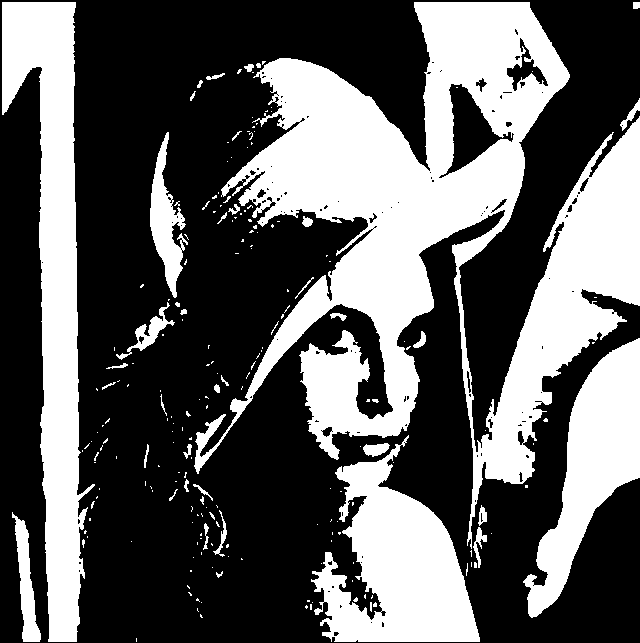

In [8]:
ret, thresh1 = cv2.threshold(greyscale_img, 151, 255, cv2.THRESH_BINARY)        
cv2_imshow(thresh1)

In [9]:
vif=vifp(thresh1, greyscale_img)
psnr=PSNR(thresh1,greyscale_img)
ssim_val=ssim(thresh1, greyscale_img)
    
'''print("psnr = "+str(round(psnr,4)))
print("vif = "+str(round(vif,4)))
print("ssim = "+str(round(ssim_val,4)))'''

print(str(round(psnr,4))+'  '+str(round(vif,4))+'  '+str(round(ssim_val,4)))

28.0362  0.1136  0.2576


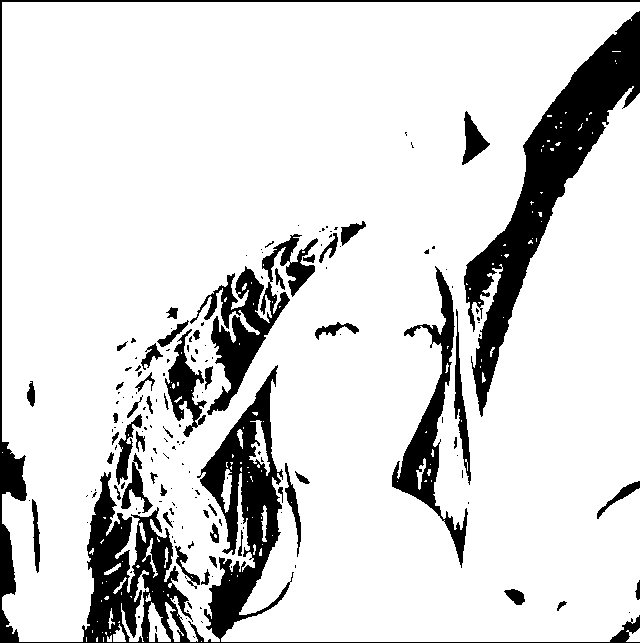

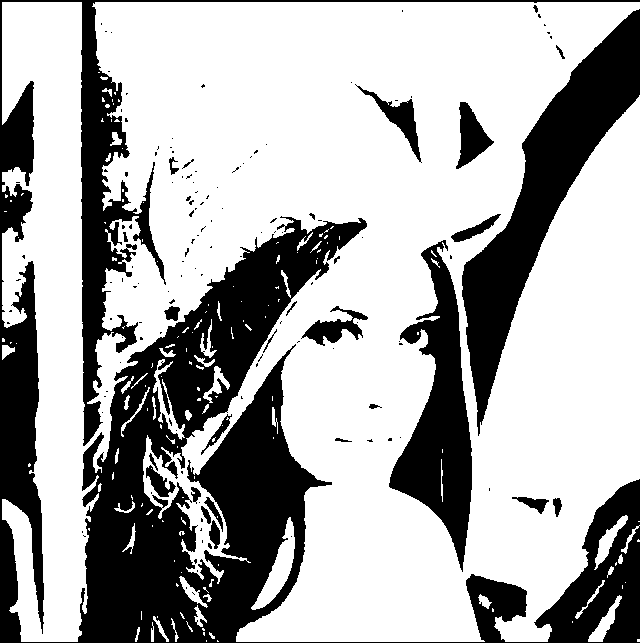

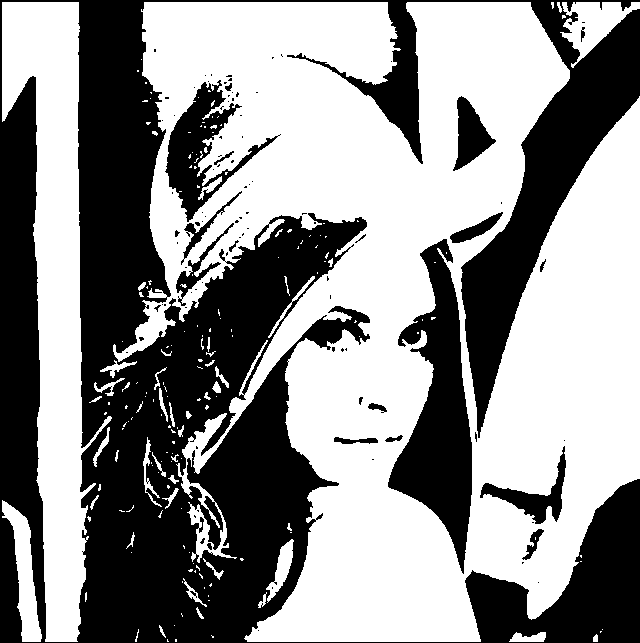

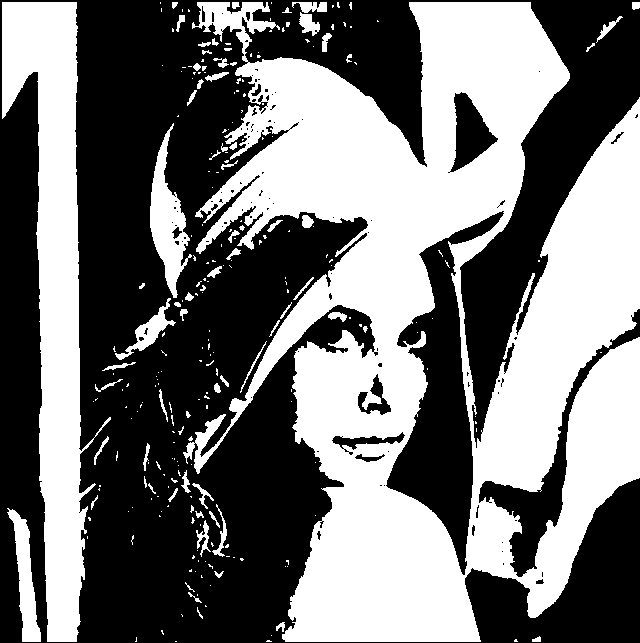

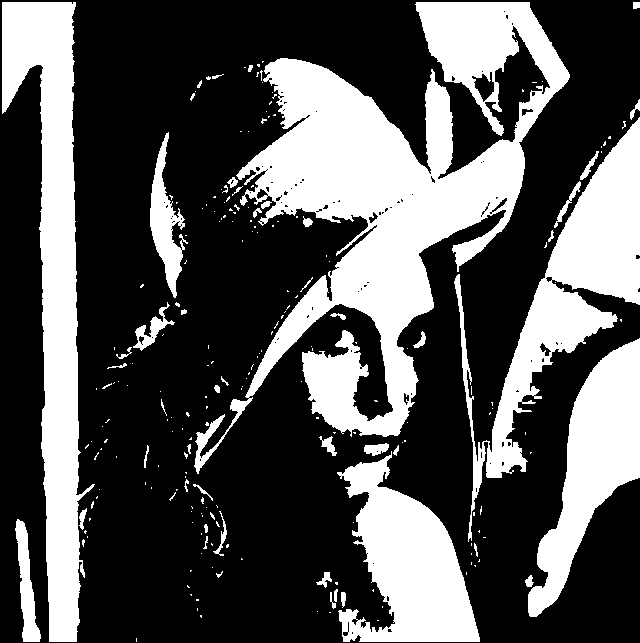

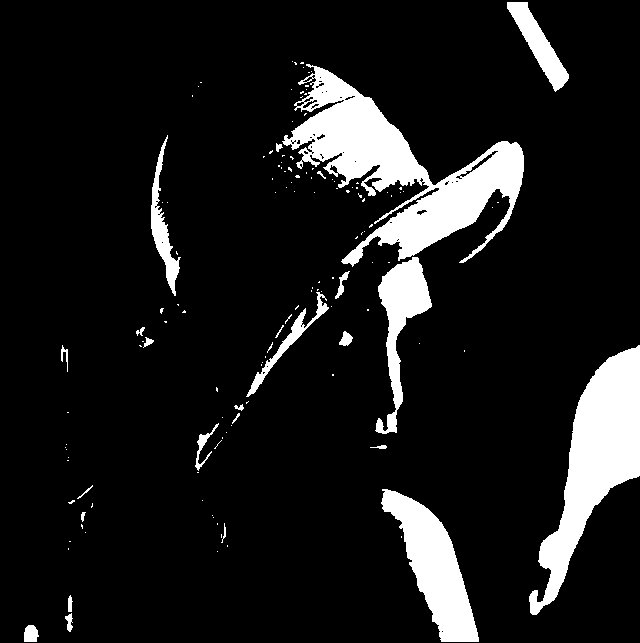

In [12]:
thresholds = [68, 112 ,130, 142, 155, 187]
sr='/content/drive/MyDrive/Dataset/lena_colour01.png'  
greyscale_img = cv2.imread(sr,0)
for i in thresholds:
  ret, thresh1 = cv2.threshold(greyscale_img, i, 255, cv2.THRESH_BINARY)
  cv2_imshow(thresh1)
  '''if(i!=0):
    ret, thresh1 = cv2.threshold(greyscale_img, i, 255, cv2.THRESH_BINARY)  
    vif=vifp(thresh1, greyscale_img)
    psnr=PSNR(thresh1,greyscale_img)
    ssim_val=ssim(thresh1, greyscale_img)
    print(str(round(psnr,4))+'  '+str(round(vif,4))+'  '+str(round(ssim_val,4)))
  else:
    print('****')'''